In [1]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm as tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import utils
import torch.nn as nn
import numpy as np
import os, imageio

import torch
import cv2

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.0.dev20230622+cu121  Device: cuda


In [3]:
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

### Dataloader

In [4]:
# image_url = r"C:/Users/ayush/OneDrive\Desktop/fox.jpg"
# img = cv2.imread(image_url)


# plt.imshow(img)
# plt.show()

# img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_64F)

# plt.imshow(img)
# plt.show()
# center = [int(img.shape[0]/2),int(img.shape[1]/2)]

# r = 256

# img = img[ center[0]-r:center[0]+r, center[1]-r:center[1]+r]

# plt.imshow(img)
# plt.show()

In [5]:
def load_image(im_path):

    img = cv2.imread(im_path)

    img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    center = [int(img.shape[0]/2),int(img.shape[1]/2)]

    # if img.shape[0]
    r = 256

    img = img[ center[0]-r:center[0]+r, center[1]-r:center[1]+r]

    return img

In [6]:
image_url = r"C:/Users/ayush/OneDrive\Desktop/fox.jpg"

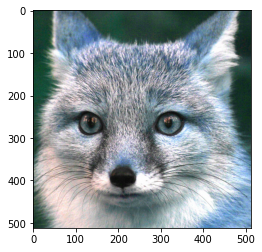

In [7]:
img = load_image(image_url)
plt.imshow(img)
plt.show()

### Converting Dataset

In [8]:
def generate_pixel_coordinates(img):
    
    height, width, _ = img.shape

    # Generate coordinates along the x-axis and y-axis
    x_coords = np.linspace(0, 1, width, endpoint=False)
    y_coords = np.linspace(0, 1, height, endpoint=False)

    # Create a meshgrid of coordinates
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)

    # Stack the coordinates and reshape to obtain the final output
    coordinates = np.stack([x_mesh, y_mesh], axis=-1)
    
    return coordinates

### Fourier Feature mapping


In [10]:
def input_mapping(x, B):
    '''
        cos and sin of input are joined together to increased the dimension to 4.
    '''
    if B is None:
        return x
    else:
        B = B.to(x)
        x_proj = (2.*np.pi*x) @ B.T #512,2
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)    #  2*len(B) #512,4

In [11]:
def batch_loader(coord_input,image,map_dict,batch_size = 64,mapping = 'none'):

    coord_input = input_mapping(coord_input, map_dict[mapping])

    test_data = [coord_input, image]
    train_data = [coord_input[::2], image[::2]]
    
    train_x = torch.tensor(train_data[0]).reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    train_y = torch.tensor(train_data[1]).reshape(-1,3)
    test_x = torch.tensor(test_data[0]).reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    test_y = torch.tensor(test_data[1]).reshape(-1,3)

    #  Can skip these and directly past train_x,train_y

    train_dataset = utils.data.TensorDataset(train_x,train_y)
    test_dataset = utils.data.TensorDataset(test_x,test_y)

    train_dataloader = utils.data.DataLoader(train_dataset,batch_size)
    validation_dataloader = utils.data.DataLoader(test_dataset,batch_size)

    return train_dataloader,validation_dataloader,test_y,coord_input.shape[2]

### MLP network

In [12]:
class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50) # input has 4 dimensions.
        self.fc1_drop = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50,3)

    def forward(self, x):
        # x = x.view(-1,4) # input has 4 dimensions.
        x = self.relu1(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc2_drop(x)
        return self.fc3(x)

In [13]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device).type(torch.float64)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)
        # print(output)


        # Calculate loss
        # print(output.shape,target.shape)
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_dataloader.dataset),
        #         100. * batch_idx / len(train_dataloader), loss.data.item()))

In [33]:
def validate(epoch,loss_vector, accuracy_vector,batch,reconst = False):
    
    model.eval()

    no_batch = (img.shape[0]*img.shape[1])//batch
    predicted_output = np.empty([no_batch,batch,3])
    
    val_loss, correct = 0, 0
    idx = 0

    for batch_idx, (data, target) in enumerate(validation_dataloader):
        
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        val_loss += criterion(output, target).data.item()
        pred = output # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        
        if reconst:
            predicted_output[batch_idx] = output.detach().cpu().numpy()

    
    val_loss /= len(validation_dataloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_dataloader.dataset)
    # print(epoch,correct.to(torch.float32),len(validation_dataloader.dataset),100. * correct.to(torch.float32) / len(validation_dataloader.dataset),accuracy)
    accuracy_vector.append(accuracy)

    # print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     val_loss, correct, len(validation_dataloader.dataset), accuracy))

    if reconst:
        return predicted_output.reshape(512,512,3)
    else:
        return 0

### Train

In [22]:
mapping_size = 64

B_dict = {}
#Standard network - no mapping
# B_dict['none'] = None
# # Basic mapping
# B_dict['basic'] = torch.eye(2)
# # Three different scales of Gaussian Fourier feature mappings
B_gauss = torch.normal(0,1,size=(mapping_size,2))
for scale in [10.]:
    B_dict[f'gauss_{scale}'] = B_gauss * scale

In [23]:
import torchvision.datasets as datasets

In [24]:
mnist_trainset = datasets.MNIST(root='./../data', train=True, download=False, transform=None)

In [25]:
x_test = torch.from_numpy(generate_pixel_coordinates(img))

In [26]:
def init_model(dimension):

    model = Net(dimension).to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    return model,optimizer,criterion

In [27]:
import time

In [31]:
def train_model(batch,epochs):

    output_epoch = []


    lossv, accv = [], []
    
    for ep in range(1, epochs + 1):
        
        t0 = time.time()
        train(ep)
        # if epoch
        output_epoch.append(validate(ep,lossv,accv,batch,reconst=True))
        print('{} Epoch no'.format(ep),'{} seconds'.format(time.time() - t0))

    return lossv,accv,output_epoch

In [34]:
output_dict = {}
batch = 1024
epoch = 300
for keys in B_dict:

    train_dataloader,validation_dataloader,test_y,input_dim = batch_loader(x_test,img,B_dict,batch,mapping=keys)
    model,optimizer,criterion = init_model(input_dim)
    output_dict[keys] = train_model(batch,epoch)

c:\MLAI\lib\site-packages\torch\utils\_device.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


1 Epoch no 5.3836705684661865 seconds
2 Epoch no 4.474714756011963 seconds
3 Epoch no 4.2227113246917725 seconds
4 Epoch no 4.014685392379761 seconds
5 Epoch no 4.618990898132324 seconds
6 Epoch no 4.308369398117065 seconds
7 Epoch no 4.100841999053955 seconds
8 Epoch no 3.9969940185546875 seconds
9 Epoch no 4.057561874389648 seconds
10 Epoch no 4.205262184143066 seconds
11 Epoch no 4.003784894943237 seconds
12 Epoch no 4.0928285121917725 seconds
13 Epoch no 4.802686929702759 seconds
14 Epoch no 5.137219429016113 seconds
15 Epoch no 5.059544324874878 seconds
16 Epoch no 5.838129997253418 seconds
17 Epoch no 5.584130048751831 seconds
18 Epoch no 4.324054002761841 seconds
19 Epoch no 4.497697353363037 seconds
20 Epoch no 4.694515228271484 seconds
21 Epoch no 4.4990129470825195 seconds
22 Epoch no 4.489832401275635 seconds
23 Epoch no 4.3144097328186035 seconds
24 Epoch no 4.370018482208252 seconds
25 Epoch no 4.493342638015747 seconds
26 Epoch no 4.626577854156494 seconds
27 Epoch no 4.5

In [35]:
def plot_reconstruction_progress(predicted_images, y, N=2):

  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))
  print(total,N,total/N)
  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j])
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  y = y.cpu().detach().numpy()
  plt.imshow(y.reshape(img.shape[0],img.shape[1],3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

In [ ]:
plot_reconstruction_progress(output_dict[keys])

### Helper function

In [ ]:
## Save and load model pytorch

# torch.save([model.args, model.state_dict()], path)
# model = model.load_state_dict(torch.load('timepass.pth'))
# for param in model.parameters():
#   print(param.data)

In [32]:
# load and save output_dict

# import pickle
# with open('fox_gamma10_300_1-241.pickle', 'wb') as handle:
#     pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('fox_gamma10.pickle', 'rb') as handle:
#     new_dict = pickle.load(handle)
# plt.imshow(new_dict[keys][2][299])

In [21]:
# axiss = np.arange(10)
# plt.plot(sgd_loss,color = 'r',label = 'sgd')
# plt.plot(lossv,color = 'g',label = 'adam')
# plt.legend()
# plt.show()

## Alternate Methods

1. The training data only happens on 50% of data.
2. Test comprises of the whole dataset rather than the remaining data.

In [9]:
# tain_images, test_images = np.split(x_test, [int(len(x_test)*0.7)])

# tain_images.shape
# test_images.shape